In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Set paths
train_dir = '/kaggle/input/ct-heart-segmentation/data/train/'
# test_dir = '/kaggle/input/ct-heart-segmentation/data/test/'

# Paramters
IMAGE_SIZE = 128 # Resize images to 128 x 128

def load_images_and_masks(data_dir, size):
    images = []
    masks = []


    for batch_folder in os.listdir(data_dir):
        batch_path = os.path.join(data_dir, batch_folder)
        image_dir = os.path.join(batch_path, "image")
        mask_dir = os.path.join(batch_path, "mask")

        image_files = sorted(os.listdir(image_dir))
        mask_files = sorted(os.listdir(mask_dir))
    
        for image_file, mask_file in zip(image_files, mask_files):
            img_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, mask_file)
    
            # Load and process
            img = Image.open(img_path).convert('L').resize((size, size))
            mask = Image.open(mask_path).convert('L').resize((size, size))
            
            images.append(np.array(img) / 255.0)
            masks.append(np.array(mask) / 255.0)

    return np.array(images), np.array(masks)

# Load data
X, y = load_images_and_masks(train_dir, IMAGE_SIZE)

X = np.expand_dims(X, axis=3)
y = np.expand_dims(y, axis=3)

print(f"Images shape: {X.shape}")
print(f"Masks shape: {y.shape}")

Images shape: (2532, 128, 128, 1)
Masks shape: (2532, 128, 128, 1)


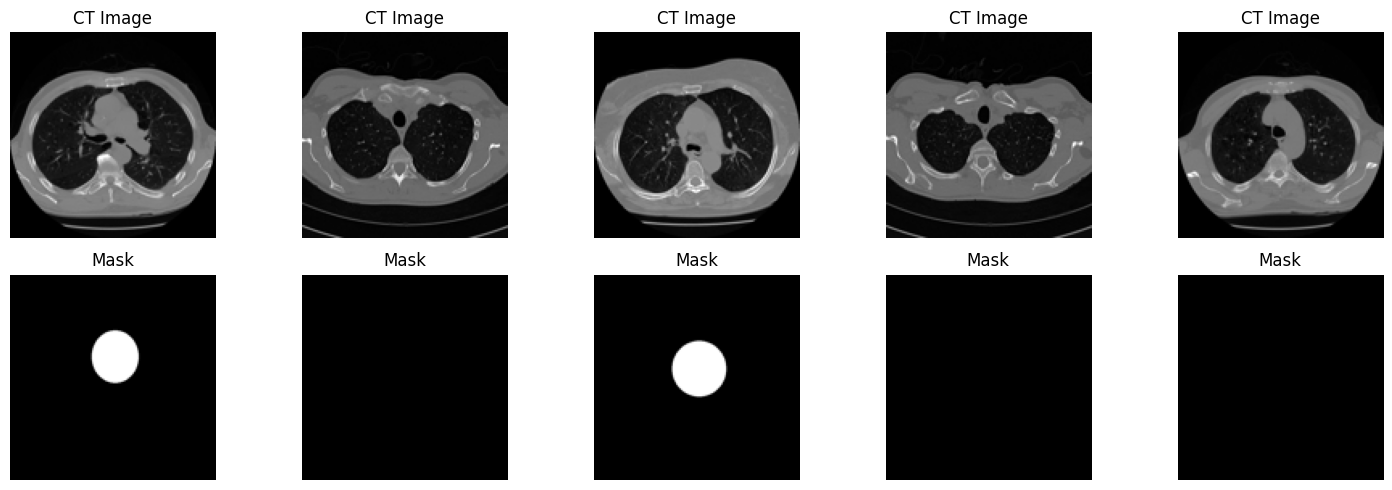

In [2]:
def display_samples(X, y, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        idx = np.random.randint(0, len(X))
        image = X[idx].squeeze()
        mask = y[idx].squeeze()

        plt.subplot(2, num, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title('CT Image')
        plt.axis('off')

        plt.subplot(2, num, i + 1 + num)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_samples(X, y)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')

Training set size: 2278
Validation set size: 254


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1) 
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3) 

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


# Build the model
model = build_unet()
model.summary()

2026-02-10 01:33:38.553364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770687218.771081      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770687218.838146      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770687219.371004      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770687219.371045      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770687219.371048      17 computation_placer.cc:177] computation placer alr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
 def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=(['accuracy', dice_coef, iou_coef])
)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('unet_best_model.keras', save_best_only=True)
]

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9187 - dice_coef: 0.1181 - iou_coef: 0.0676 - loss: 0.2544 - val_accuracy: 0.9730 - val_dice_coef: 0.3663 - val_iou_coef: 0.2249 - val_loss: 0.0571
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9734 - dice_coef: 0.4521 - iou_coef: 0.3042 - loss: 0.0491 - val_accuracy: 0.9880 - val_dice_coef: 0.7251 - val_iou_coef: 0.5717 - val_loss: 0.0260
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9871 - dice_coef: 0.7043 - iou_coef: 0.5514 - loss: 0.0286 - val_accuracy: 0.9902 - val_dice_coef: 0.8003 - val_iou_coef: 0.6699 - val_loss: 0.0190
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9890 - dice_coef: 0.7941 - iou_coef: 0.6626 - loss: 0.0215 - val_accuracy: 0.9914 - val_dice_coef: 0.8607 - val_iou_coef: 0.7581 - val_loss: 0.0185
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9917 - dice_coef: 0.8493 - iou_coef: 0.7419 - loss: 0.0152 - val_accuracy

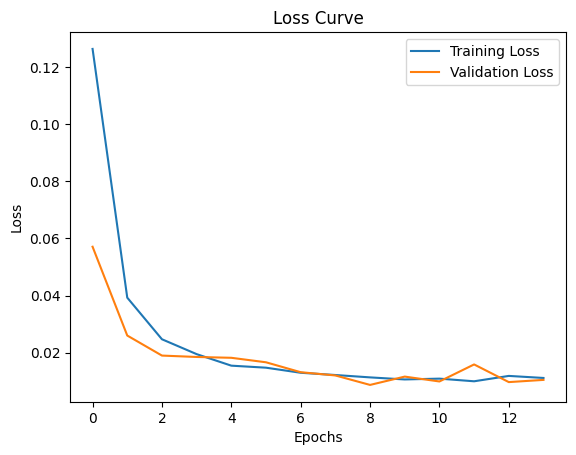

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
val_loss, val_accuracy, val_dice, val_iou = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss: .4f}")
print(f"Validation Accuracy: {val_accuracy: .4f}")
print(f"Validation Dice Coefficient: {val_dice: .4f}")
print(f"Validation IoU Coefficient: {val_iou: .4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step - accuracy: 0.9945 - dice_coef: 0.9114 - iou_coef: 0.8375 - loss: 0.0078
Validation Loss:  0.0087
Validation Accuracy:  0.9940
Validation Dice Coefficient:  0.9061
Validation IoU Coefficient:  0.8287


In [10]:
preds = model.predict(X_val)
# This gives you binary masks: 1 for predicted heart region, 0 for background
preds = (preds > 0.5).astype('byte')

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step


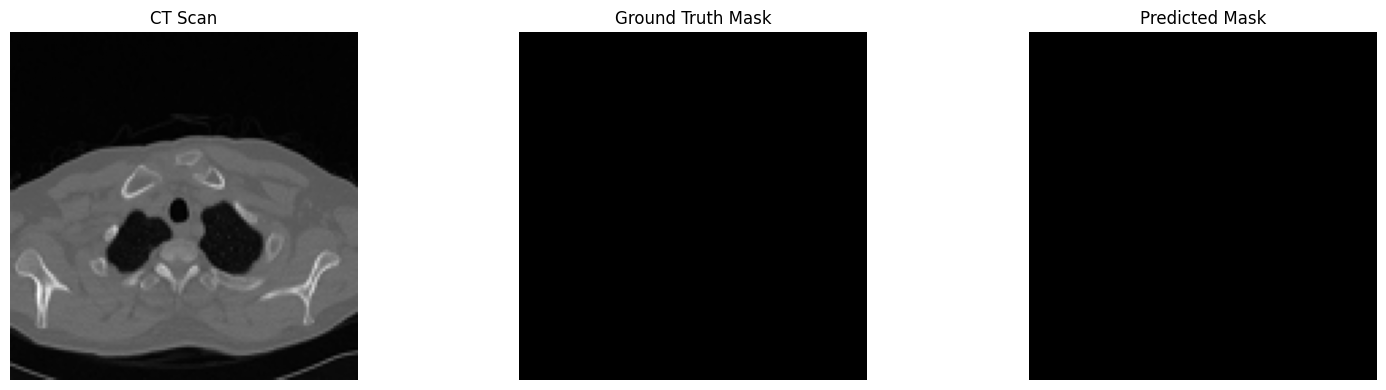

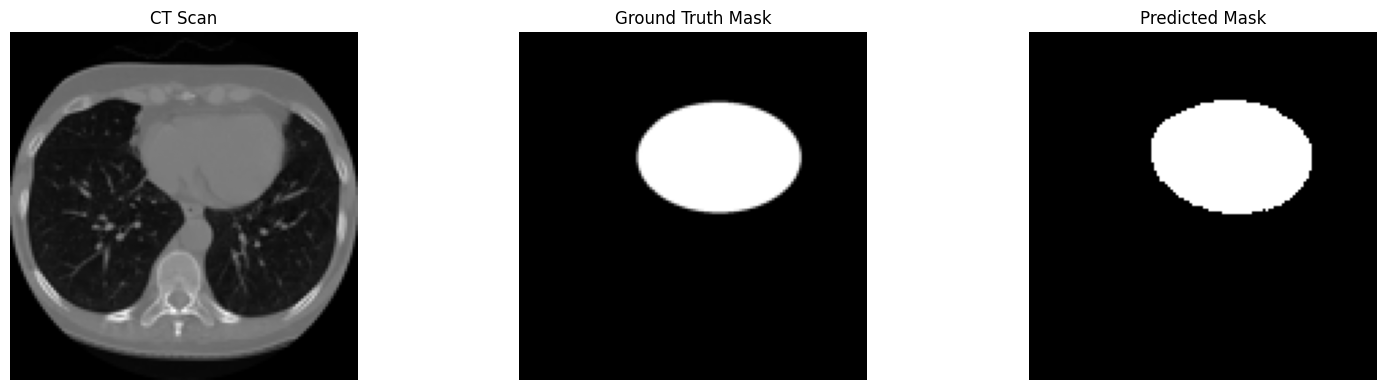

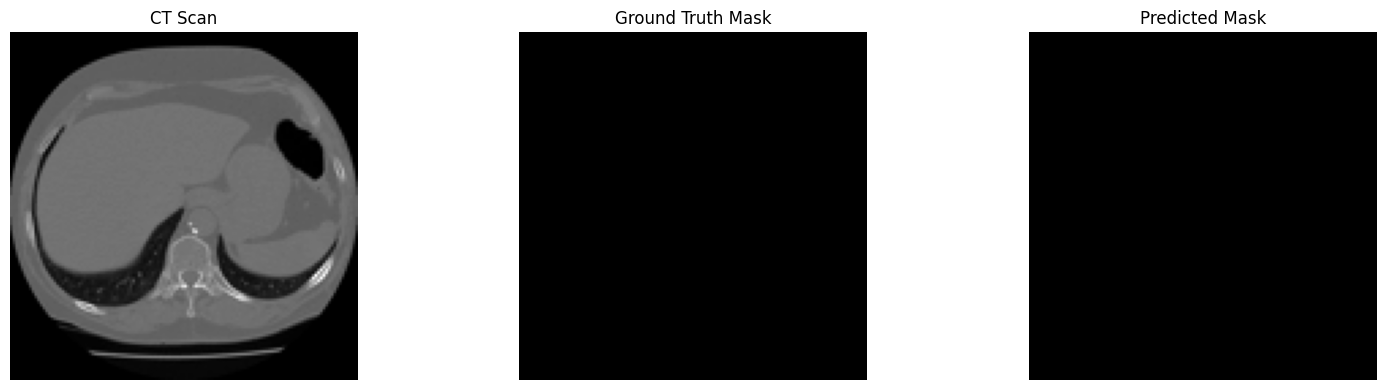

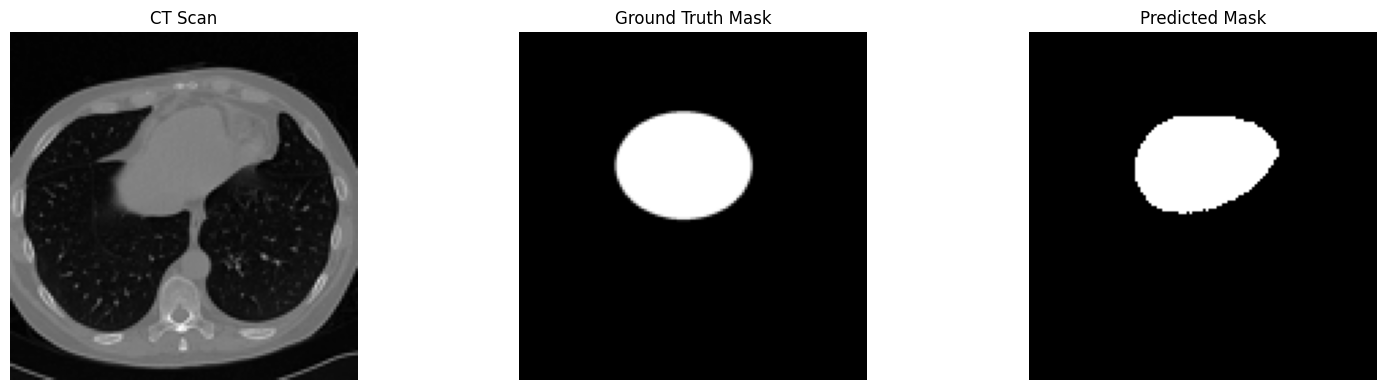

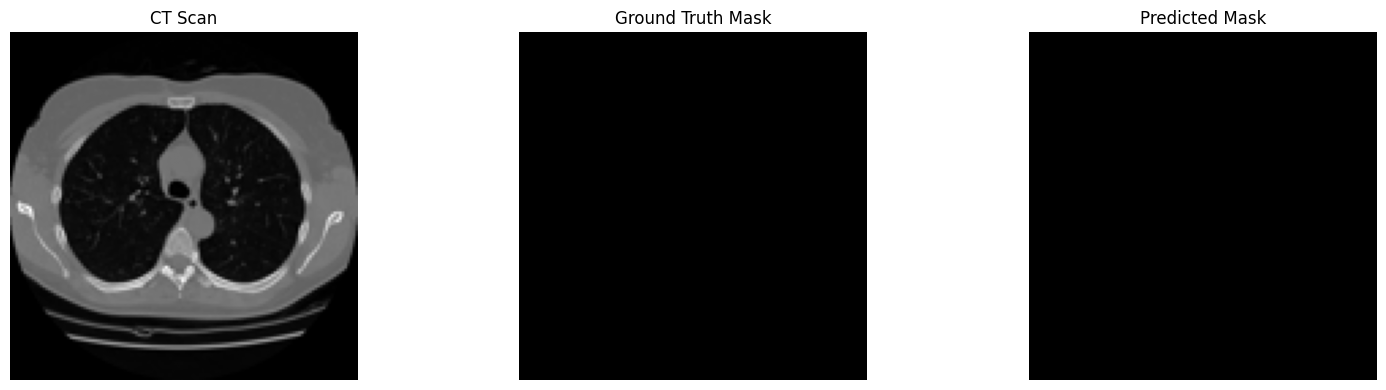

In [11]:
import random
import matplotlib.pyplot as plt

def plot_sample(i):
    plt.figure(figsize=(16, 4))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title('CT Scan')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show random 5 examples
for _ in range(5):
    plot_sample(random.randint(0, len(X_val) - 1))

In [12]:
model.save("heart_segmentation_model.h5")